In [1]:
import os
from dotenv import load_dotenv  
import h5py
import pandas as pd
import numpy as np
# from albk.data.utils import get_google_maps_static_image
import geopandas as gpd
# load_dotenv()
import os
import io

import h5py
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from IPython.display import clear_output

from numcodecs import GZip, Zstd, Blosc

# from albk.data.utils import get_google_maps_static_image

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import requests


# First written by @dhruvpatel44
def get_google_maps_static_image(
    api_key, lat_lon: str, zoom=17, scale=1, size=(224, 244), format="png8", maptype="satellite"
):
    """Get a static image from Google Maps API.

    Args:
        api_key: API key for Google Maps API. See https://developers.google.com/maps/documentation/maps-static/get-api-key. You may first need to enable "Google Maps Static API" in your Google Cloud Console.
        lat_lon: format "lat,lon"
        zoom: Zoom level passed to Google Maps API.
        scale: Scale passed to Google Maps API. If scale=2, the image will have 2x pixels for the same area.
        size: Size of the image in pixels in (rows, columns) format.
        format: Format of the image. See https://developers.google.com/maps/documentation/maps-static/start#ImageFormats
        maptype: Type of map. See https://developers.google.com/maps/documentation/maps-static/start#MapTypes

    Raises:
        ValueError: If response code is not 200 or if image is not found.

    Returns:
        Image bytes.
    """
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": lat_lon,
        "zoom": zoom,
        "size": f"{size[0]}x{size[1]}",
        "maptype": maptype,
        "key": api_key,
        "scale": scale,
        "format": format,
    }
    response = requests.get(base_url, params=params)
    img = response.content
    code = response.status_code
    if code != 200:
        raise ValueError("Request failed with code: " + str(code) + " and message: " + str(img))
    if len(img) < 1000:
        raise ValueError("Image not found. Message: " + str(img))
    return img


Shapefile is downloaded from: 

| Country/City | Link |
| --- | --- |
| Bangladesh | https://www.kaggle.com/datasets/tsgreen/bangladesh-administrative-boundaries-shapefiles/data |
| West Bengal | https://www.kaggle.com/datasets/saptarsi/west-bengal-shape-file/ |
| India | https://www.kaggle.com/datasets/ankitgaikar1995/india-district-level-shape-file-2022 |

<Axes: >

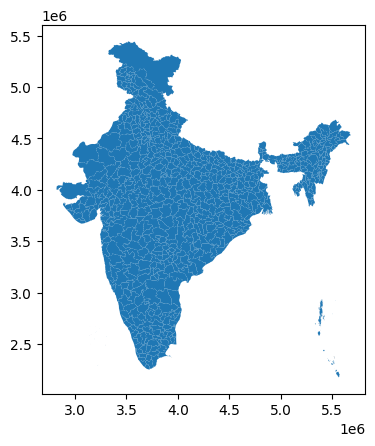

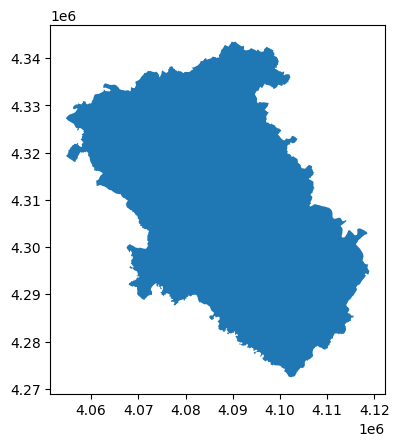

In [10]:
geometry = 'india'
gdf = gpd.read_file(f'shapefiles/{geometry}/DISTRICT_BOUNDARY.shp')
# gdf.head()
gdf.plot();
gdf['District'] = gdf['District'].str.replace('>', 'A')
gdf['STATE'] = gdf['STATE'].str.replace('>', 'A')
# gdf.head()
# delhi_dgf = gdf[gdf['STATE'] == 'DELHI']
# west_bengal_gdf = gdf[gdf['STATE'] == 'WEST BENGAL']
# odihsa_gdf = gdf[gdf['STATE'] == 'ODISHA']
# up_dgf = gdf[gdf['STATE'] == 'UTTAR PRADE
# bihar_dgf = gdf[gdf['STATE'] == 'BIHAR']
# delhi_dgf.plot();
# west_bengal_gdf.plot();
# odihsa_gdf.plot();
# up_dgf.plot();
# bihar_dgf.plot()

# state_gdf = gdf[gdf['STATE'] == 'HARYANA']
# state_gdf.plot()

lucknow_gdf_city = gdf[gdf['District'] == 'LUCKNOW']
lucknow_gdf_city.plot()

<Axes: >

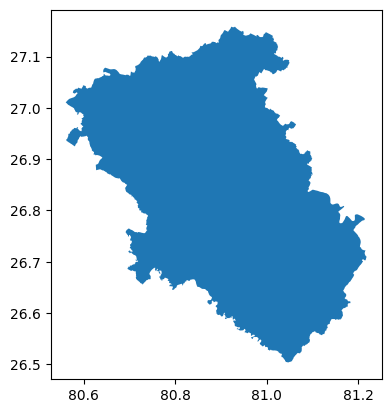

In [11]:
lucknow_gdf_city = lucknow_gdf_city.to_crs(epsg=4326)
lucknow_gdf_city.plot()

In [3]:
lucknow_gdf = gpd.read_file('/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/data_preprocessing/grids_lucknow.csv')
lucknow_gdf.head()

,id,name,Grid Number,WKT,geometry
0,1535789,Grid 1,1,"POLYGON Z ((80.65 26.6 0, 80.65 26.61000000000...","POLYGON Z ((80.65000 26.60000 0.00000, 80.6500..."
1,1535800,Grid 2,2,"POLYGON Z ((80.66000000000001 26.6 0, 80.66000...","POLYGON Z ((80.66000 26.60000 0.00000, 80.6600..."
2,1535811,Grid 3,3,"POLYGON Z ((80.67 26.6 0, 80.67 26.61000000000...","POLYGON Z ((80.67000 26.60000 0.00000, 80.6700..."
3,1535822,Grid 4,4,"POLYGON Z ((80.68 26.6 0, 80.68 26.61000000000...","POLYGON Z ((80.68000 26.60000 0.00000, 80.6800..."
4,1535833,Grid 5,5,"POLYGON Z ((80.69000000000001 26.6 0, 80.69000...","POLYGON Z ((80.69000 26.60000 0.00000, 80.6900..."


<Axes: >

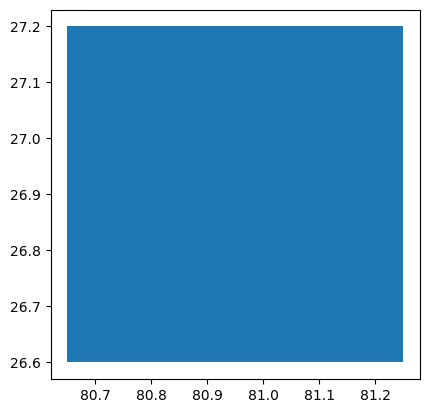

In [4]:
lucknow_gdf.plot()

In [13]:
# lucknow_gdf = lucknow_gdf.to_crs(epsg=4326)
# lucknow_gdf.plot()

In [5]:
unary_shape = lucknow_gdf.unary_union
min_lon, min_lat, max_lon, max_lat = unary_shape.bounds
print(min_lon, min_lat, max_lon, max_lat) 

80.65 26.6 81.25000000000001 27.200000000000003


In [6]:
# The following gap has some overlap but it is choosen to have multiples of 0.01
lat_gap = 0.01
lon_gap = 0.01
lats = np.arange(np.round(min_lat, 2)-lat_gap, np.round(max_lat, 2)+lat_gap*2, lat_gap)
lons = np.arange(np.round(min_lon, 2)-lon_gap, np.round(max_lon, 2)+lon_gap*2, lon_gap)
print(len(lats), len(lons), len(lats)*len(lons))

63 63 3969


In [7]:
Lat, Lon = np.meshgrid(lats, lons)
latlon_pairs = np.vstack([Lat.ravel(), Lon.ravel()]).T
print(latlon_pairs.shape)

(3969, 2)


In [8]:
from shapely.geometry import Point
from joblib import Parallel, delayed
from tqdm import tqdm

In [9]:
point_gdf = gpd.GeoDataFrame(geometry=[Point(y, x) for x, y in latlon_pairs])
def check_within(gdf_chunk):
    return gdf_chunk.within(unary_shape).values

chunk_size = 100
chunks = [point_gdf[i:i+chunk_size] for i in range(0, len(point_gdf), chunk_size)]
results = Parallel(n_jobs=48)(delayed(check_within)(chunk) for chunk in tqdm(chunks))
latlon_bool = np.concatenate(results)
print(len(latlon_bool), latlon_bool.sum())

100%|██████████| 40/40 [00:00<00:00, 3534.05it/s]


3969 3481


In [10]:
latlon_pairs_in_geometry = latlon_pairs[latlon_bool]

def convert_to_string(latlon_pair):
    lat, lon = latlon_pair
    return f'{lat:.2f},{lon:.2f}'

latlon_pairs_in_geometry = [convert_to_string(latlon_pair) for latlon_pair in latlon_pairs_in_geometry]

print(latlon_pairs_in_geometry[:3])
print(len(latlon_pairs_in_geometry))

['26.61,80.66', '26.62,80.66', '26.63,80.66']
3481


In [11]:
from numcodecs import GZip
from matplotlib import pyplot as plt    
import io
import xarray as xr

In [12]:
def download_it(lat_lon):
    # Download image
    img_bytes = get_google_maps_static_image(key, lat_lon, zoom=16, size=(640, 640), scale=2)
    img_io = io.BytesIO(img_bytes)
    img = plt.imread(img_io)
    
    # Center crop to allow 5x5 patches of size 224x224x3 from 1120x1120x3
    cut_img = img[80:-80, 80:-80, :3]
    assert cut_img.shape == (224*5, 224*5, 3), f"cut_img.shape = {cut_img.shape}"
    
    # Split into 5x5 patches: (5, 5, 224, 224, 3)
    data = np.array([np.split(tmp_img, 5, axis=1) for tmp_img in np.split(cut_img, 5, axis=0)])
    data = (data * 255).astype(np.uint8)
    
    save_path = os.path.join(path, f"{lat_lon}.zarr")
    # os.makedirs(save_path, exist_ok=True)
    # for i in range(5):
    #     for j in range(5):
            # save image
            # plt.imsave(os.path.join(save_path, f"{i}_{j}.png"), data[i, j])
            # np.save(os.path.join(save_path, f"{i}_{j}.npy"), data[i, j])
            # np.savez_compressed(os.path.join(save_path, f"{i}_{j}.npz"), data[i, j])
            
            # save in h5 format
            # with h5py.File(os.path.join(save_path, f"{i}_{j}.h5"), 'w') as f:
            #     f.create_dataset('data', data=data[i, j], compression='gzip')
            # pass
    
    # Convert to xarray dataset
    lat, lon = lat_lon.split(',')
    lat, lon = float(lat), float(lon)
    ds = xr.Dataset(
    {
        'data': (['lat_lag', 'lon_lag', 'row', 'col', 'channel'], data),
        'label': (['lat_lag', 'lon_lag'], labels),
    },
    coords={
        'lat': lat,
        'lon': lon,
        'row': rows,
        'col': cols,
        'channel': channels,
        'lat_lag': lat_lag,
        'lon_lag': lon_lag,
    },
    )
    encoding = {'data': {'compressor': GZip(level=9)}}
    ds.to_zarr(save_path, consolidated=False, encoding=encoding, mode='w')

In [15]:
# state = 'lucknow'
# geometry = 'india'

lat_lag = np.array([-2, -1, 0, 1, 2], dtype=np.int8)
lon_lag = np.array([-2, -1, 0, 1, 2], dtype=np.int8)
rows = np.array(np.arange(224), dtype=np.uint8)
cols = np.array(np.arange(224), dtype=np.uint8)
channels = np.array([0, 1, 2], dtype=np.uint8)
labels = (np.zeros((5, 5)) - 1).astype(np.int8)
# path = os.path.join(os.path.expanduser("~"), 'bkdb', geometry,state)
path = os.path.expanduser("/home/rishabh.mondal/bkdb/lucknow_grid_data")

key = os.getenv('DHRUV_GMS') # DHRUV_GMS, ZEEL_IITGN_GMS, SURAJ_GMS, ZEEL_GMS, ANONY_GMS, VISHESH_GMS, SMTGML_GMS
print(path)

/home/rishabh.mondal/bkdb/lucknow_grid_data


In [16]:
# We got these pairs after finding closest pairs to predicted brick kilns
special_pairs = []

In [17]:
existing_folders = os.listdir(path)
def check_if_exists(folder):
    try:
        ds = xr.open_zarr(os.path.join(path, folder), consolidated=False)
        assert ds.data.shape == (5, 5, 224, 224, 3)
        return True
    except Exception as e:
        # print(e)
        return False
    # files = os.listdir(os.path.join(path, folder))
    # return set(files) == set([f"{i}_{j}.png" for i in range(5) for j in range(5)])

does_exists = Parallel(n_jobs=48)(delayed(check_if_exists)(folder) for folder in tqdm(existing_folders))
existing_pairs = [folder.replace(".zarr", "") for folder, exists in zip(existing_folders, does_exists) if exists]

to_download_pairs = sorted(set(latlon_pairs_in_geometry+special_pairs) - set(existing_pairs))
print(len(latlon_pairs_in_geometry+special_pairs), "in", geometry)
print(len(existing_pairs), "already downloaded")
print(len(to_download_pairs), "to download")

_ = Parallel(n_jobs=48)(delayed(download_it)(lat_lon) for lat_lon in tqdm(to_download_pairs))

0it [00:00, ?it/s]


3481 in india
0 already downloaded
3481 to download


100%|██████████| 3481/3481 [01:49<00:00, 31.78it/s]


In [18]:
print("path:", path)

path: /home/rishabh.mondal/bkdb/lucknow_grid_data


In [19]:
files = glob(os.path.join(path, "*.zarr"))
ds = xr.open_zarr(files[888], consolidated=False)
ds.sel(lat_lag=0, lon_lag=0)['data']

<xarray.DataArray 'data' (row: 224, col: 224, channel: 3)>
[150528 values with dtype=uint8]
Coordinates:
  * channel  (channel) uint8 0 1 2
  * col      (col) uint8 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223
    lat      float64 ...
    lat_lag  int8 0
    lon      float64 ...
    lon_lag  int8 0
  * row      (row) uint8 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223

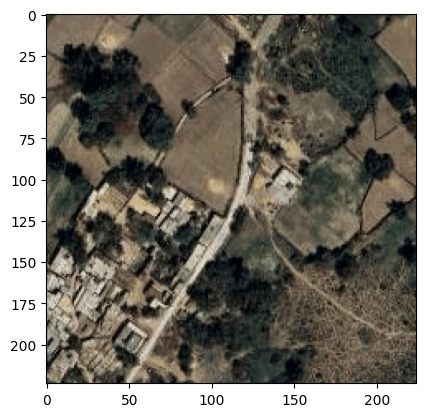

In [20]:
plt.imshow(ds.sel(lat_lag=0, lon_lag=0)['data'])

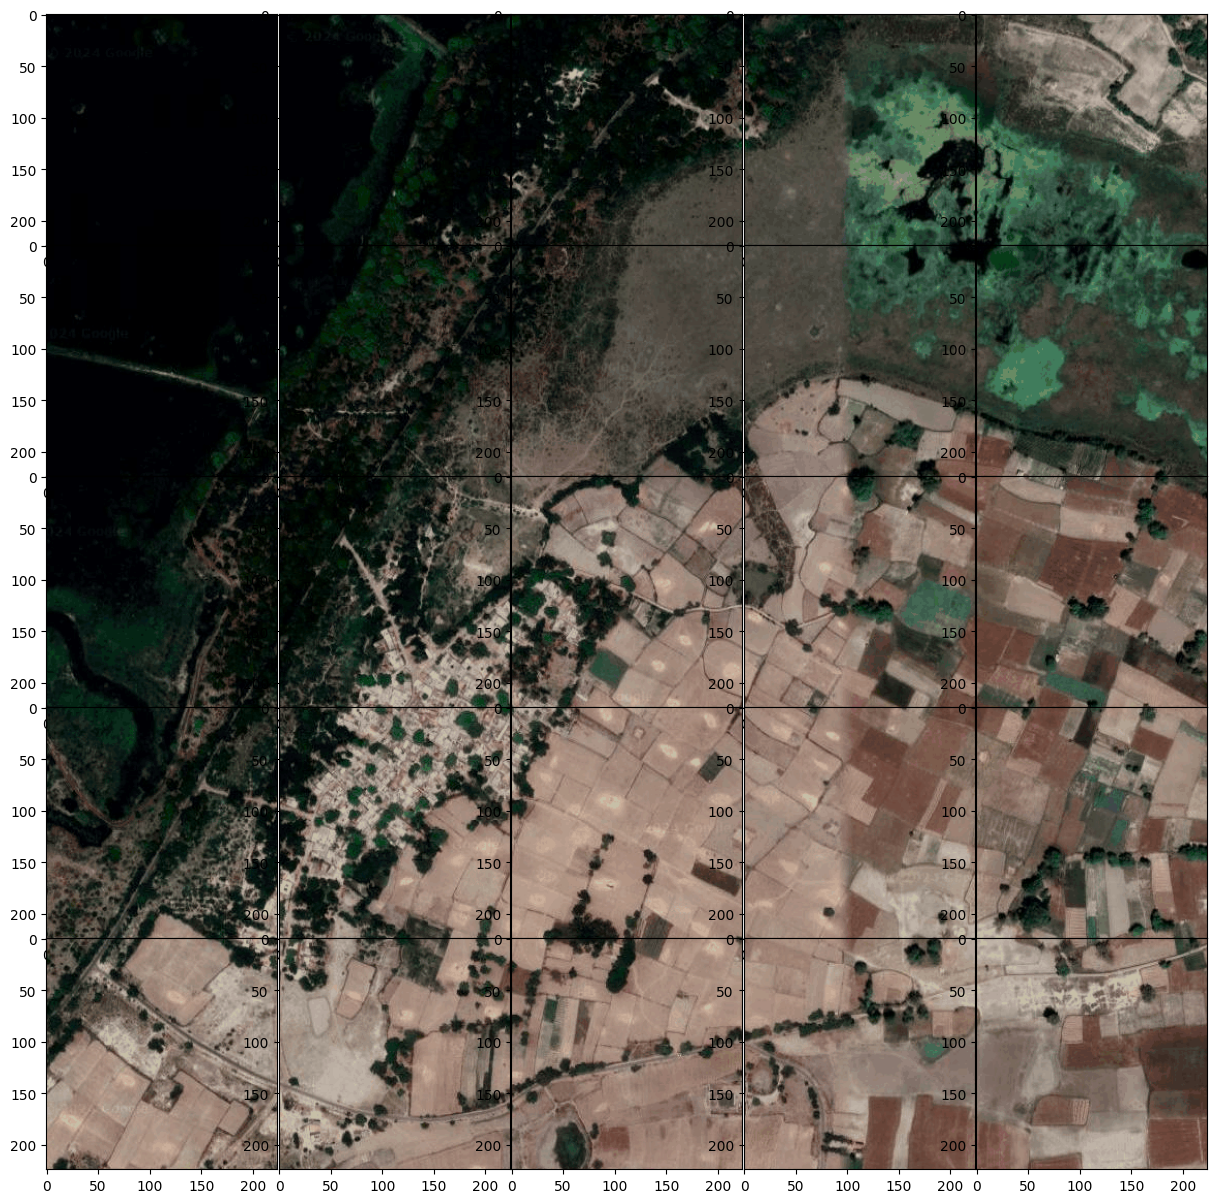

In [22]:
ds = xr.open_zarr("/home/rishabh.mondal/bkdb/lucknow_grid_data/26.61,80.66.zarr/", consolidated=False)
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(ds.isel(lat_lag=i, lon_lag=j)['data'])